# Predicting flat prices
This project can be used for apartment price prediction based on a set of parameters by choosing the best model from the following:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- GradientBoostingRegressor;
- CatBoostRegressor;
- XGBRegressor.

INPUT: LandContour, GarageYrBlt, BsmtFullBath, 1stFlrSF, BsmtFinSF1, TotRmsAbvGrd, ExterQual, OpenPorchSF, Heating, Condition2, OverallQual, GarageCars, KitchenQual, GrLivArea, 2ndFlrSF, CentralAir, BsmtQual, TotalBsmtSF, Fireplaces.

OUTPUT: SalePrice

In [ ]:
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


# Libraries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame, get_dummies
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Dataset preprocessing


## Constants

In [24]:
LAND_CONTOUR_KEY = 'LandContour'
GARAGE_YR_BLT_KEY = 'GarageYrBlt'
FULL_BATH_KEY = 'FullBath'
FIRST_FLR_SF_KEY = '1stFlrSF'
BSMT_FIN_SF_1_KEY = 'BsmtFinSF1'
TOT_RMS_ABV_GRD_KEY = 'TotRmsAbvGrd'
EXTER_QUAL_KEY = 'ExterQual'
OPEN_PORCH_SF_KEY = 'OpenPorchSF'
HEATING_KEY = 'Heating'
CONDITION_2_KEY = 'Condition2'
OVERALL_QUAL_KEY = 'OverallQual'
GARAGE_CARS_KEY = 'GarageCars'
KITCHEN_QUAL_KEY = 'KitchenQual'
KITCHEN_ABV_GR_KEY = 'KitchenAbvGr'
GR_LIV_AREA_KEY = 'GrLivArea'
SECOND_FLR_SF_KEY = '2ndFlrSF'
CENTRAL_AIR_KEY = 'CentralAir'
BSMT_QUAL_KEY = 'BsmtQual'
TOTAL_BSMT_SF_KEY = 'TotalBsmtSF'
FIREPLACES_KEY = 'Fireplaces'

SALE_PRICE_KEY = 'SalePrice'
ID_KEY = 'Id'

MODEL_KEY = 'Model'
R2_KEY = 'R2'

categorical_data_keys = [LAND_CONTOUR_KEY, EXTER_QUAL_KEY, HEATING_KEY,
                         CONDITION_2_KEY, KITCHEN_QUAL_KEY, CENTRAL_AIR_KEY,
                         BSMT_QUAL_KEY]

## File creating functions


In [33]:
def create_formatted_file(df, filename):
    df.to_csv(f'{filename}', index=False, encoding='utf-8')


def create_result_file(df):
    df.to_csv(f'result.csv', index=False, encoding='utf-8')

## Dataset formatting

Filling na fields, deleting correlating fields, saving file.

In [29]:
def format_dataset(dataset, filename):
    # processing na fields
    for column in [LAND_CONTOUR_KEY, GARAGE_YR_BLT_KEY, FULL_BATH_KEY, TOT_RMS_ABV_GRD_KEY,
                   EXTER_QUAL_KEY, HEATING_KEY, CONDITION_2_KEY, GARAGE_CARS_KEY, KITCHEN_ABV_GR_KEY,
                   OVERALL_QUAL_KEY, KITCHEN_QUAL_KEY, CENTRAL_AIR_KEY, BSMT_QUAL_KEY, FIREPLACES_KEY]:
        dataset.loc[:, column] = dataset[column].fillna(dataset[column].mode()[0])

    for column in [FIRST_FLR_SF_KEY, BSMT_FIN_SF_1_KEY, OPEN_PORCH_SF_KEY,
                   GR_LIV_AREA_KEY, SECOND_FLR_SF_KEY, TOTAL_BSMT_SF_KEY]:
        dataset.loc[:, column] = dataset[column].fillna(dataset[column].mean())

    # deleting corr fields
    corr_fields = [GR_LIV_AREA_KEY, FIRST_FLR_SF_KEY]
    new_dataset = dataset.drop(corr_fields, axis=1)

    create_formatted_file(new_dataset, f'{filename}')

## Correlation coefficients

Calculating correlation coefficients in order to remove the columns that are the most dependent on each other.

In [27]:
MAX_ACCEPTABLE_CORR = 0.8


def check_corr_emptiness(corr_coefficients):
    field_drop = [i for i in corr_coefficients if corr_coefficients[i].isnull().drop_duplicates().values[0]]
    print('\t', field_drop)


def check_corr_coefficients(corr_coefficients):
    for column in corr_coefficients:
        for row in corr_coefficients.index[corr_coefficients[column] > MAX_ACCEPTABLE_CORR]:
            if column != row:
                print('\t', column, " -> ", row, ": r^2 = ",
                      corr_coefficients[column][corr_coefficients.index == row].values[0])

When formatting the files while calculating the correlation coefficients, we learn the following:

    1stFlrSF  ->  TotalBsmtSF : r^2 =  0.8195299750050339
    TotRmsAbvGrd  ->  GrLivArea : r^2 =  0.8254893743088424
    GrLivArea  ->  TotRmsAbvGrd : r^2 =  0.8254893743088424
    TotalBsmtSF  ->  1stFlrSF : r^2 =  0.8195299750050339

Therefore, the following columns will be deleted:

    GR_LIV_AREA_KEY
    FIRST_FLR_SF_KEY

# Models comparing and information






## Models comparison

Model comparison using RMSE in order to choose the best one for apartment price prediction.


In [ ]:
def compare_models(x_train, y_train):
    models = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor(),
              GradientBoostingRegressor(),
              CatBoostRegressor(verbose=False),
              XGBRegressor(objective='reg:squarederror'),
              ]
    model_names = ['LinearRegression',
                   'DecisionTreeRegressor',
                   'RandomForestRegressor',
                   'GradientBoostingRegressor',
                   'CatBoostRegressor',
                   'XGBRegressor'
                   ]
    print('MSE:')
    for i in range(len(models)):
        model = models[i]
        model_name = model_names[i]
        rmse = np.mean(np.sqrt(-cross_val_score(model, x_train, y_train.values.ravel(),
                                                cv=5, scoring="neg_mean_squared_error")))
        print('\t', model_name, round(rmse, 4))


    LinearRegression  36492.6932
    DecisionTreeRegressor  43780.7469
    RandomForestRegressor  31252.2144
    GradientBoostingRegressor  31285.3437
    CatBoostRegressor  30275.6273
    XGBRegressor  31789.3788

## Feature importances


Function to find out the importance of each parameter.

In [ ]:
def print_feature_importances(column_keys, model):
    print('Feature importances:')
    feature_importances = model.feature_importances_
    for i in range(len(feature_importances)):
        print('\t', round(feature_importances[i], 3), column_keys[i])

    1.832 LandContour
    3.826 GarageYrBlt
    4.336 FullBath
    9.033 BsmtFinSF1
    6.325 TotRmsAbvGrd
    2.576 ExterQual
    4.266 OpenPorchSF
    0.071 Heating
    0.341 Condition2
    21.776 OverallQual
    7.641 GarageCars
    4.928 KitchenQual
    0.749 KitchenAbvGr
    8.67 2ndFlrSF
    1.161 CentralAir
    2.605 BsmtQual
    14.639 TotalBsmtSF
    5.223 Fireplaces

# Program

MSE CatBoostRegressor: 28552.166103258067


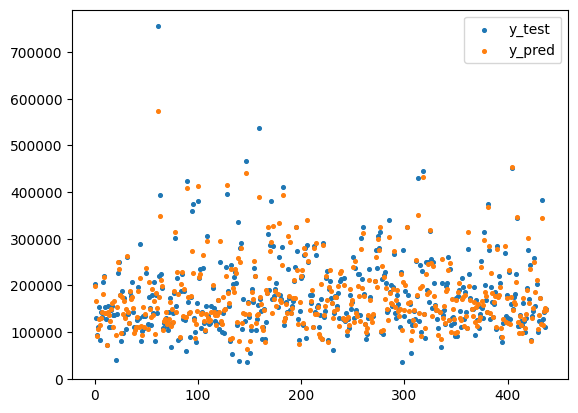

In [34]:
# format files
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')
format_dataset(train_dataset, 'formatted_train.csv')
format_dataset(test_dataset, 'formatted_test.csv')

# one-hot encoding
combined_data = pd.concat([train_dataset, test_dataset], keys=['train', 'test'])
combined_dummies = pd.get_dummies(combined_data, columns=categorical_data_keys)
train_dataset = combined_dummies.xs('train')
test_dataset = combined_dummies.xs('test')

x = train_dataset.drop(columns=[SALE_PRICE_KEY])
y = train_dataset[SALE_PRICE_KEY]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# choose the best model
model = CatBoostRegressor(verbose=False)
model = model.fit(x_train, y_train.values.ravel())

y_pred = model.predict(x_test)
mse = np.mean(np.sqrt(-cross_val_score(model, x_test, y_test.to_numpy(), cv=5, scoring="neg_mean_squared_error")))
print(f'MSE CatBoostRegressor: {mse}')

# graph for comparing
plt.figure()
plt.scatter(range(len(y_test)), y_test, s=7, label="y_test")
plt.scatter(range(len(y_test)), y_pred, s=7, label="y_pred")
plt.legend()
plt.show()

# creating file with result predicted data
test_prediction = model.predict(test_dataset)

result_dataset = pd.DataFrame({ID_KEY: range(len(test_dataset)),
                               SALE_PRICE_KEY: test_prediction})
create_result_file(result_dataset)
